In [1]:
import wandb
from tqdm.auto import tqdm
import pandas as pd

def get_summary_metrics(sweep_id, filter_func=None):
  api = wandb.Api(timeout=60)
  sweep = api.sweep(sweep_id)

  data = []
  for run in tqdm(sweep.runs, desc='Runs', leave=False):
    if callable(filter_func) and not filter_func(run):
      continue
    
    run_summary = dict(run_id=run.id, **run.config, **run.summary)

    data.append(run_summary)

  return sweep, pd.DataFrame(data)

In [2]:
# _, metrics = get_summary_metrics('deeplearn/fspace-inference/wngy4n4z')
# _, metrics = get_summary_metrics('deeplearn/fspace-inference/hen90pon')

metrics = metrics[['run_id', 'seed', 'reg_scale', 's/test/acc', 's/test/sel_acc', 's/test/avg_nll', 's/test/ece']]
metrics['s/test/acc'] *= 100.
metrics['s/test/err'] = 100 - metrics['s/test/acc'] 
metrics['s/test/sel_err'] = 100 - metrics['s/test/sel_acc'] 
metrics['s/test/ece'] *= 100.
metrics['mode'] = metrics.reg_scale.apply(lambda v: 'lmap' if float(v) > 0. else 'ps')
metrics = metrics.drop(columns=['reg_scale', 's/test/acc', 's/test/sel_acc'])
metrics = metrics.rename(columns={
    's/test/err': 'Err.',
    's/test/sel_err': 'Sel. Err.',
    's/test/ece': 'ECE',
    's/test/avg_nll': 'NLL',
})

Runs:   0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
results = metrics.melt(id_vars=['run_id', 'seed', 'mode'], var_name='metric')
results.columns

Index(['run_id', 'seed', 'mode', 'metric', 'value'], dtype='object')

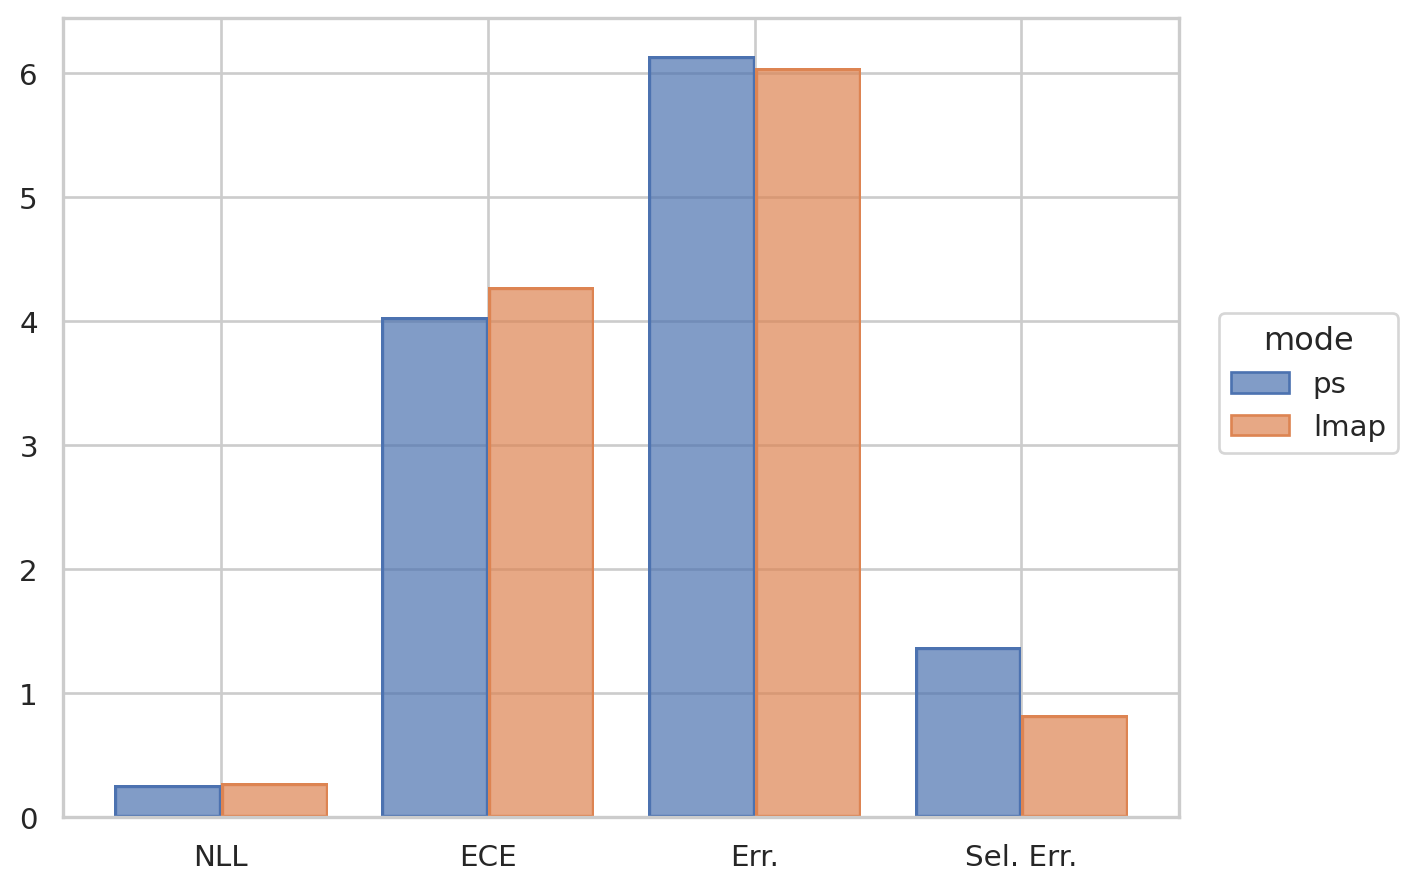

In [23]:
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, style='whitegrid')


# fig, _ = plt.subplots(figsize=(8,2))
(
    so.Plot(results, x='metric', y='value', color='mode')
      .add(so.Bar(), so.Agg(), so.Dodge())
      .label(x='', y='')
      .theme({**sns.axes_style("whitegrid")})
)

# f.show()
# g = sns.barplot(results, x='mode', y='value', hue='mode', col='metric',
#                 col_order=['Err.', 'Sel. Err.', 'NLL', 'ECE'],
#                 errorbar='sd', order=['lmap', 'ps'], palette=sns.color_palette('Set2', 2),
#                 sharey=False)

# # g = sns.FacetGrid(results, col='metric', height=2.5, aspect=.6, sharey=False,
# #                   col_order=['Err.', 'Sel. Err.', 'NLL', 'ECE'])
# # bp = g.map(sns.barplot, 'mode', 'value', errorbar='sd', order=['lmap', 'ps'], palette=sns.color_palette('Set2', 2))
# g.set(xlabel='', ylabel='', xticklabels=[r'L', r'PS'])
# g.set_titles(col_template=r"{col_name}")

# g.fig.tight_layout()
# g.fig.show()

# g.fig.savefig('tmp.pdf', bbox_inches='tight')